In [17]:
import torch

# Define the Python function for f1 and f2 as provided in the image
def f1(x):
    # Squeeze the middle dimension to make sure we have a m*4 tensor
    x_squeezed = x.squeeze(1)
    return -3.95 + 9.20 * torch.sigmoid(-0.32 + 5.06*x_squeezed[:,0] - 4.07*x_squeezed[:,1] - 0.36*x_squeezed[:,2] - 0.34*x_squeezed[:,3]) + \
           9.88 * torch.sigmoid(-4.83 + 7.43*x_squeezed[:,0] + 3.46*x_squeezed[:,1] + 9.19*x_squeezed[:,2] + 16.58*x_squeezed[:,3]) + \
           10.84 * torch.sigmoid(-7.90 - 7.91*x_squeezed[:,0] - 4.48*x_squeezed[:,1] - 4.08*x_squeezed[:,2] - 8.28*x_squeezed[:,3]) + \
           15.18 * torch.sigmoid(-9.41 - 7.99*x_squeezed[:,0] + 0.65*x_squeezed[:,1] + 3.14*x_squeezed[:,2] + 0.31*x_squeezed[:,3])

def f2(x):
    # Squeeze the middle dimension to make sure we have a m*4 tensor
    x_squeezed = x.squeeze(1)
    return 1.07 + 0.62 * torch.sigmoid(-3.05 + 0.03*x_squeezed[:,0] + 0.16*x_squeezed[:,1] + 4.03*x_squeezed[:,2] - 0.54*x_squeezed[:,3]) + \
           0.65 * torch.sigmoid(-1.78 + 0.60*x_squeezed[:,0] - 3.19*x_squeezed[:,1] + 0.10*x_squeezed[:,2] + 0.54*x_squeezed[:,3]) - \
           0.72 * torch.sigmoid(-0.01 + 2.04*x_squeezed[:,0] - 3.73*x_squeezed[:,1] + 0.10*x_squeezed[:,2] - 1.05*x_squeezed[:,3]) - \
           0.45 * torch.sigmoid(-1.82 + 4.78*x_squeezed[:,0] + 0.48*x_squeezed[:,1] - 4.68*x_squeezed[:,2] - 1.65*x_squeezed[:,3]) - \
           0.32 * torch.sigmoid(-2.69 + 5.99*x_squeezed[:,0] + 3.87*x_squeezed[:,1] + 3.10*x_squeezed[:,2] - 2.17*x_squeezed[:,3])

# Define the combined function f3
def objective(x):
    # Calculate f3 using f1 and f2
    return ((60 - f1(x)) / 60) * (f2(x) / 1.5)

In [15]:
# use a GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dtype = torch.double

In [8]:
import gpytorch
from torch import Tensor

from botorch.models import FixedNoiseGP
from botorch.models.transforms import Standardize
from gpytorch.mlls import ExactMarginalLogLikelihood
from botorch.fit import fit_gpytorch_model

In [9]:
def fit_gp_model(X, Y, Yvar=None):
    if X.ndim == 1:
        X = X.unsqueeze(dim=-1)
    if Y.ndim == 1:
        Y = Y.unsqueeze(dim=-1)
    model = FixedNoiseGP(X, Y, torch.ones(Y.shape) * 1e-4, outcome_transform=Standardize(m=Y.shape[-1]))
    mll = ExactMarginalLogLikelihood(model.likelihood, model)
    fit_gpytorch_model(mll)
    return model

In [10]:
from torch.autograd import (Function, grad)
from botorch.acquisition import AnalyticAcquisitionFunction
from botorch.models.model import Model
from botorch.acquisition.analytic import (_scaled_improvement, _ei_helper)
from botorch.acquisition.objective import PosteriorTransform
from typing import Dict, Optional, Tuple, Union
from botorch.utils.transforms import t_batch_mode_transform
from botorch.utils.probability.utils import (
    ndtr as Phi,
    phi,
)

In [57]:
class GittinsIndexFunction(Function):
    @staticmethod
    def forward(X: torch.Tensor, mean: torch.Tensor, sigma: torch.Tensor, cost: float, maximize: bool, bounds: torch.Tensor, eps: float):
        
        def cost_adjusted_expected_improvement(best_f):
            u = _scaled_improvement(mean, sigma, best_f, maximize)
            return sigma * _ei_helper(u) - cost

        size = X.size()[0]
        l = bounds[0]*torch.ones(size)
        h = bounds[1]*torch.ones(size)
        m = (h + l) / 2

        if maximize:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) < 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) > 0):
                h = 2 * h
        else:
            while torch.any(cost_adjusted_expected_improvement(best_f=l) > 0):
                l = 2 * l
            while torch.any(cost_adjusted_expected_improvement(best_f=h) < 0):
                h = 2 * h

        # Bisection method
#         while torch.max(torch.abs(cost_adjusted_expected_improvement(best_f=m))) >= eps:
        for _ in range(100):
            sgn_m = torch.sign(cost_adjusted_expected_improvement(best_f=m))
            if maximize:
                l = torch.where(sgn_m >= 0, m, l)
                h = torch.where(sgn_m <= 0, m, h)
            else:
                l = torch.where(sgn_m <= 0, m, l)
                h = torch.where(sgn_m >= 0, m, h)
            m = (h + l) / 2
            
        return m
    
    @staticmethod
    def setup_context(ctx, inputs, output):
        X, mean, sigma, cost, maximize, bounds, eps = inputs
        
        # Save u for backward computation
        u = _scaled_improvement(mean, sigma, output, maximize)
        
        # Save values needed in the backward pass
        ctx.save_for_backward(X, mean, sigma, u)
        
        # Save boolean flag directly in ctx
        ctx.maximize = maximize  

    @staticmethod
    def backward(ctx, grad_output):
                
        # Retrieve saved tensors
        X, mean, sigma, u = ctx.saved_tensors
        maximize = ctx.maximize  # Retrieve the boolean flag directly from ctx
                
        # Gradient of mean function with respect to x
        dmean_dX = grad(outputs=mean, inputs=X, grad_outputs=torch.ones_like(mean), retain_graph=True, allow_unused=True)[0].clone()

        # Gradient of the std function with respect to x
        dsigma_dX = grad(outputs=sigma, inputs=X, grad_outputs=torch.ones_like(sigma), retain_graph=True, allow_unused=True)[0].clone()
        
        # Check if gradients are None and handle accordingly
        if dmean_dX is None or dsigma_dX is None:
            raise RuntimeError("Gradients could not be computed for one or more components.")
        
        # Compute the gradient of the Gittins acquisition function
        if maximize:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX + phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))
        else:
            grad_X = grad_output.unsqueeze(-1).unsqueeze(-1) * (dmean_dX - phi(u).unsqueeze(-1).unsqueeze(-1) * dsigma_dX / Phi(u).unsqueeze(-1).unsqueeze(-1))

        return grad_X, None, None, None, None, None, None

In [12]:
class GittinsIndex(AnalyticAcquisitionFunction):
    r"""Single-outcome Gittins Index (analytic).

    Computes Gittins index using the analytic formula for a Normal posterior distribution. Unlike the
    MC-based acquisition functions, this relies on the posterior at single test
    point being Gaussian (and require the posterior to implement `mean` and
    `variance` properties). Only supports the case of `q=1`. The model must be
    single-outcome.

    `GI(x) = argmin_g |E(max(f(x) - g, 0))-cost|,`

    where the expectation is taken over the value of stochastic function `f` at `x`.

    Example:
        >>> model = SingleTaskGP(train_X, train_Y)
        >>> GI = GittinsIndex(model, cost=0.05)
        >>> gi = GI(test_X)
        
    """

    def __init__(
        self,
        model: Model,
        cost: float,
        posterior_transform: Optional[PosteriorTransform] = None,
        maximize: bool = True,
        bounds: torch.Tensor = torch.tensor([[-1.0], [1.0]], dtype=torch.float64),
        eps: float = 1e-6
    ):
        r"""Single-outcome Gittins Index (analytic).
        
        Args:
            model: A fitted single-outcome model.
            cost: Either a scalar or a `b`-dim Tensor (batch mode) representing
                the cost function.
            posterior_transform: A PosteriorTransform. If using a multi-output model,
                a PosteriorTransform that transforms the multi-output posterior into a
                single-output posterior is required.
            maximize: If True, consider the problem a maximization problem.
            bounds: A `2 x d` tensor of lower and upper bounds for each column of `X`.
        """
        super().__init__(model=model, posterior_transform=posterior_transform)
        self.cost = cost
        self.maximize = maximize
        self.bounds = bounds
        self.eps = eps
      
        
    @t_batch_mode_transform(expected_q=1)
    def forward(self, X: Tensor) -> Tensor:
        r"""Evaluate Gittins Index on the candidate set X using bisection method.

        Args:
            X: A `(b1 x ... bk) x 1 x d`-dim batched tensor of `d`-dim design points.
                Gittins Index is computed for each point individually,
                i.e., what is considered are the marginal posteriors, not the joint.

        Returns:
            A `(b1 x ... bk)`-dim tensor of Gittins Index values at the
            given design points `X`.
        """
        
        mean, sigma = self._mean_and_sigma(X)
#         mean = self.model.posterior(X).mean.squeeze(-2).squeeze(-1)
#         sigma = self.model.posterior(X).variance.sqrt().squeeze(-2).squeeze(-1)
            
        return GittinsIndexFunction.apply(X, mean, sigma, self.cost, self.maximize, self.bounds, self.eps)

In [82]:
from botorch.acquisition import ExpectedImprovement
from botorch.optim import optimize_acqf

seed = 42

maximize = True 

num_iterations = 40

torch.manual_seed(seed)

x = torch.rand(10, 4, device=device, dtype=dtype).requires_grad_(True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
EI_best = [best_f] # This will store the best value

for i in range(num_iterations):
    
    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize EI
    BoTorch_EI = ExpectedImprovement(model=model, best_f=best_f, maximize=maximize)
    new_point, new_point_EI = optimize_acqf(
        acq_function=BoTorch_EI,
        bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]]),
        q=1,
        num_restarts=40,
        raw_samples=400,
        options={},
    )
    
    new_value = objective(new_point)
    
    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    EI_best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.11187595 0.42373687 1.         0.5917849 ]]
new value: 0.6934027075767517
best oberved value: 0.6934027075767517

Iteration: 1
new point: [[0.01931297 0.44735402 1.         0.9168324 ]]
new value: 0.7561575770378113
best oberved value: 0.7561575770378113

Iteration: 2
new point: [[-0.21556103  0.3249234   0.9848357   0.8457353 ]]
new value: 0.8303751349449158
best oberved value: 0.8303751349449158



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.44155678  0.41037136  0.87545997  0.852367  ]]
new value: 0.8142523765563965
best oberved value: 0.8303751349449158



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.38188788  0.08351872  1.          0.944436  ]]
new value: 0.8586493134498596
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.48090577  0.01209885  1.          0.68805414]]
new value: 0.8445667624473572
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.39472234 -0.0532208   0.79703856  0.88099134]]
new value: 0.7841343879699707
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.6174114   0.14895913  1.          0.94852185]]
new value: 0.818794846534729
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.3933995   0.16863362  1.          0.8103902 ]]
new value: 0.8550941348075867
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.70956624  0.433702    1.          0.31987116]]
new value: 0.7807573080062866
best oberved value: 0.8586493134498596

Iteration: 10
new point: [[-0.93853545 -0.40812868  1.          0.24652094]]
new value: 0.7525675892829895
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-0.4458704  -0.63468575  1.          1.        ]]
new value: 0.7822137475013733
best oberved value: 0.8586493134498596

Iteration: 12
new point: [[-1.          0.22437689  0.3537008   0.10510418]]
new value: 0.7291802167892456
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-1.          0.19133458  0.80117196 -0.7387695 ]]
new value: 0.6691114902496338
best oberved value: 0.8586493134498596

Iteration: 14
new point: [[-0.5043975  1.         1.         1.       ]]
new value: 0.7785278558731079
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-1.         -1.          0.18551992 -0.1170254 ]]
new value: 0.5094829201698303
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-2.9750189e-01 -7.7740505e-04  1.0000000e+00  1.0000000e+00]]
new value: 0.8532801270484924
best oberved value: 0.8586493134498596



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.3598519   0.21986797  1.          1.        ]]
new value: 0.8590558767318726
best oberved value: 0.8590558767318726



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-1.         1.         0.4634848  0.6859267]]
new value: 0.572711169719696
best oberved value: 0.8590558767318726



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.36347252  0.2109016   1.          1.        ]]
new value: 0.8592827916145325
best oberved value: 0.8592827916145325



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-0.37232652  0.1520135   1.          0.9209017 ]]
new value: 0.8581227660179138
best oberved value: 0.8592827916145325

Iteration: 21
new point: [[-0.9140018   0.83189505 -0.01444114 -0.6889893 ]]
new value: 0.6447451114654541
best oberved value: 0.8592827916145325



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-1. -1.  1.  1.]]
new value: 0.6623169779777527
best oberved value: 0.8592827916145325



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.36259934  0.19264431  1.          1.        ]]
new value: 0.8596562743186951
best oberved value: 0.8596562743186951



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.7849899   0.5088231  -0.69553816  0.32404265]]
new value: 0.7356360554695129
best oberved value: 0.8596562743186951

Iteration: 25
new point: [[-0.5842837   1.         -1.         -0.39773774]]
new value: 0.4740558862686157
best oberved value: 0.8596562743186951



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.92803043  0.06716558 -0.56179553  1.        ]]
new value: 0.7272025346755981
best oberved value: 0.8596562743186951



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.7852489   0.28001416 -0.23556355  0.3735884 ]]
new value: 0.757970929145813
best oberved value: 0.8596562743186951



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.5641418   0.84055775 -0.5346217   1.        ]]
new value: 0.63688725233078
best oberved value: 0.8596562743186951



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-0.3645027  0.2653138  1.         1.       ]]
new value: 0.8577417731285095
best oberved value: 0.8596562743186951



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.36845466  0.11450787  1.          1.        ]]
new value: 0.8605063557624817
best oberved value: 0.8605063557624817



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-0.65827864 -0.4195197  -0.82312995  0.45160434]]
new value: 0.628229558467865
best oberved value: 0.8605063557624817



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-1.          0.12708667 -0.45602062 -0.01120823]]
new value: 0.6359711289405823
best oberved value: 0.8605063557624817



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-0.37585008  0.1650262   1.          0.90686053]]
new value: 0.8577370047569275
best oberved value: 0.8605063557624817



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.3801735   0.08591967  1.          1.        ]]
new value: 0.8605880737304688
best oberved value: 0.8605880737304688



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-0.54502845 -0.20377061  1.          0.29171938]]
new value: 0.7931660413742065
best oberved value: 0.8605880737304688

Iteration: 36
new point: [[-1.         0.6188754 -1.         0.9174757]]
new value: 0.7477980852127075
best oberved value: 0.8605880737304688



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.3592525   0.17515096  1.          1.        ]]
new value: 0.8599157929420471
best oberved value: 0.8605880737304688



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.36802095  0.2726989   1.          1.        ]]
new value: 0.8574723601341248
best oberved value: 0.8605880737304688



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[-0.37494156  0.10042424  1.          1.        ]]
new value: 0.8605778813362122
best oberved value: 0.8605880737304688



Text(0.5, 1.0, 'Performance of EI policy')

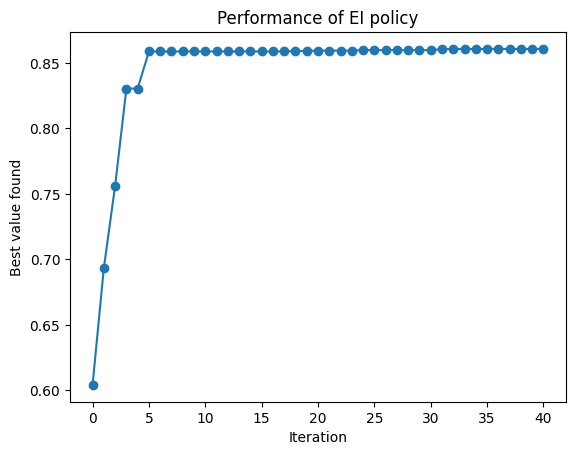

In [83]:
import matplotlib.pyplot as plt

plt.plot(EI_best,'o-')
plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy")

In [88]:
GI_best_dict = {}

In [89]:
def test_Gittins(seed, maximize, cost, num_iterations, GI_best_dict):
    
    torch.manual_seed(seed)
    
    x = torch.rand(10, 4, device=device, dtype=dtype).requires_grad_(True)
    y = objective(x).unsqueeze(-1)  # add output dimension

    if maximize:
        best_f = y.max().item() 
    else:
        best_f = y.min().item() 

    GI_best = [best_f] # This will store the best value

    for i in range(num_iterations):

        # Fit the model
    #     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
        model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

        # Optimize GI
        GI = GittinsIndex(model=model, cost=cost, maximize=maximize)
        if maximize:
            new_point, new_point_GI = optimize_acqf(
                acq_function=GI,
                bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]]),
                q=1,
                num_restarts=40,
                raw_samples=400,
                options={'method': 'L-BFGS-B'},
            )
        else:
            neg_GI = lambda X: -GI(X)
            new_point, new_point_neg_GI = optimize_acqf(
                acq_function=neg_GI,
                bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]], dtype=torch.float64),
                q=1,
                num_restarts=40,
                raw_samples=400,
                options={'method': 'L-BFGS-B'},
            )
            new_point_GI = -new_point_neg_GI

        new_value = objective(new_point)

        print("Iteration:", i)
        print("new point:", new_point.detach().numpy())
        print("new value:", new_value.item())

        #cross_validation(x,y,nu=0.5)


        # Add the new data
        x = torch.cat((x,new_point))
        y = torch.cat((y,new_value.unsqueeze(-1)))

        if maximize:
            best_f = max(best_f, new_value.item())
        else:
            best_f = min(best_f, new_value.item())

        GI_best.append(best_f)
        print("best oberved value:", best_f)
        print()
        
    GI_best_dict[cost] = GI_best

In [90]:
cost=0.01
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.0392906  0.42102888 1.         0.7129568 ]]
new value: 0.7297431230545044
best oberved value: 0.7297431230545044

Iteration: 1
new point: [[-0.25541088  0.31382185  0.90019864  0.7362143 ]]
new value: 0.8093884587287903
best oberved value: 0.8093884587287903



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.35579345  0.53837365  0.92075914  1.        ]]
new value: 0.8202759027481079
best oberved value: 0.8202759027481079



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.45663863  0.12199193  1.          1.        ]]
new value: 0.856736958026886
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.7167457  0.3005253  1.         0.7895936]]
new value: 0.7712770700454712
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.46718392  0.07344183  0.70636517  1.        ]]
new value: 0.7671700716018677
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.2860778   0.18520677  1.          1.        ]]
new value: 0.8561781644821167
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.38602084  0.24595714  1.          1.        ]]
new value: 0.8580703735351562
best oberved value: 0.8580703735351562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.3703949   0.17846891  1.          1.        ]]
new value: 0.8599236607551575
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.370656   0.1816611  1.         1.       ]]
new value: 0.8598692417144775
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 10
new point: [[-0.37070662  0.1825601   1.          1.        ]]
new value: 0.8598534464836121
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-0.370716    0.18292607  1.          1.        ]]
new value: 0.8598470687866211
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.37071347  0.18310024  1.          1.        ]]
new value: 0.8598440885543823
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-0.37070942  0.18319406  1.          1.        ]]
new value: 0.8598424792289734
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
new point: [[-0.37070492  0.1832479   1.          1.        ]]
new value: 0.8598415851593018
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.37069973  0.1832828   1.          1.        ]]
new value: 0.8598409295082092
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-0.37069455  0.18331088  1.          1.        ]]
new value: 0.8598403334617615
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.37069082  0.18332393  1.          1.        ]]
new value: 0.8598402142524719
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.3706874   0.18333572  1.          1.        ]]
new value: 0.8598399758338928
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.37068498  0.18334392  1.          1.        ]]
new value: 0.8598397970199585
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-0.3706819   0.18335061  1.          1.        ]]
new value: 0.8598397374153137
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.3707565  0.183335   1.         1.       ]]
new value: 0.859839916229248
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.3706786   0.18336324  1.          1.        ]]
new value: 0.8598394989967346
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.37067738  0.18336685  1.          1.        ]]
new value: 0.8598393797874451
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.37067658  0.18337093  1.          1.        ]]
new value: 0.8598393797874451
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
new point: [[-0.37067574  0.1833755   1.          1.        ]]
new value: 0.8598393201828003
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.3706751   0.18338038  1.          1.        ]]
new value: 0.8598390817642212
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.37067494  0.18338744  1.          1.        ]]
new value: 0.8598390221595764
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.37067437  0.18338454  1.          1.        ]]
new value: 0.8598390817642212
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-0.37067392  0.18339074  1.          1.        ]]
new value: 0.859839141368866
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.37067327  0.18339224  1.          1.        ]]
new value: 0.8598390221595764
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-0.370673    0.18339132  1.          1.        ]]
new value: 0.8598390221595764
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-0.37067276  0.18338907  1.          1.        ]]
new value: 0.859839141368866
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-0.37067273  0.18338913  1.          1.        ]]
new value: 0.859839141368866
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.37067264  0.18339203  1.          1.        ]]
new value: 0.8598390817642212
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-0.37067366  0.18339615  1.          1.        ]]
new value: 0.8598390221595764
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.37067467  0.18340062  1.          1.        ]]
new value: 0.8598389625549316
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.37067434  0.1833998   1.          1.        ]]
new value: 0.8598389625549316
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.37067404  0.18339938  1.          1.        ]]
new value: 0.8598388433456421
best oberved value: 0.8599236607551575



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[-0.37067422  0.18339951  1.          1.        ]]
new value: 0.8598388433456421
best oberved value: 0.8599236607551575



In [91]:
cost=0.02
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.07990743 0.4299673  1.         0.6566356 ]]
new value: 0.7099400162696838
best oberved value: 0.7099400162696838

Iteration: 1
new point: [[-0.15591066  0.33664924  0.94585365  0.7190615 ]]
new value: 0.7952448129653931
best oberved value: 0.7952448129653931



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.24573678  0.3771136   0.9674587   0.981936  ]]
new value: 0.8346102237701416
best oberved value: 0.8346102237701416



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.4626683   0.34883535  0.88353235  0.90249455]]
new value: 0.8169733881950378
best oberved value: 0.8346102237701416



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.31567907  0.12056707  1.          1.        ]]
new value: 0.8584542274475098
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.31207052  0.1429924   1.          1.        ]]
new value: 0.8583056330680847
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.31210786  0.14207703  1.          1.        ]]
new value: 0.858307421207428
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.3121377   0.14178133  1.          1.        ]]
new value: 0.8583089709281921
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.31215364  0.14162801  1.          1.        ]]
new value: 0.858309805393219
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.31216386  0.1415303   1.          1.        ]]
new value: 0.858310341835022
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 10
new point: [[-0.31217098  0.14146347  1.          1.        ]]
new value: 0.8583106994628906
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-0.31217614  0.14141442  1.          1.        ]]
new value: 0.858311116695404
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.31218055  0.1413788   1.          1.        ]]
new value: 0.8583113551139832
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-0.31218463  0.14135438  1.          1.        ]]
new value: 0.8583115935325623
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
new point: [[-0.31218806  0.14133379  1.          1.        ]]
new value: 0.8583117723464966
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.31219167  0.14131817  1.          1.        ]]
new value: 0.8583118915557861
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-0.3121956   0.14130986  1.          1.        ]]
new value: 0.8583121299743652
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.3121312   0.14148666  1.          1.        ]]
new value: 0.8583081364631653
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.31219953  0.14128487  1.          1.        ]]
new value: 0.8583124876022339
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.31220293  0.14128298  1.          1.        ]]
new value: 0.8583125472068787
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-0.31220347  0.14127345  1.          1.        ]]
new value: 0.8583125472068787
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.3122064  0.1412609  1.         1.       ]]
new value: 0.8583128452301025
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.31220847  0.14125428  1.          1.        ]]
new value: 0.8583130240440369
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.31221023  0.1412479   1.          1.        ]]
new value: 0.8583130240440369
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.31221223  0.14124207  1.          1.        ]]
new value: 0.8583130836486816
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
new point: [[-0.31221455  0.14123729  1.          1.        ]]
new value: 0.8583133816719055
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.31201845  0.1415151   1.          1.        ]]
new value: 0.8583008050918579
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.31221774  0.14122888  1.          1.        ]]
new value: 0.8583136200904846
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.31222025  0.14122802  1.          1.        ]]
new value: 0.8583136796951294
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-0.31222302  0.14122982  1.          1.        ]]
new value: 0.8583138585090637
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.31222615  0.1412355   1.          1.        ]]
new value: 0.8583140969276428
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-0.31222832  0.14123078  1.          1.        ]]
new value: 0.8583142161369324
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-0.3122311   0.14123243  1.          1.        ]]
new value: 0.8583143949508667
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-0.31223378  0.14123434  1.          1.        ]]
new value: 0.858314573764801
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.31223622  0.14123827  1.          1.        ]]
new value: 0.8583147525787354
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-0.31223765  0.14122647  1.          1.        ]]
new value: 0.8583148121833801
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.31224     0.14122742  1.          1.        ]]
new value: 0.8583149909973145
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.3122423   0.14122842  1.          1.        ]]
new value: 0.858315110206604
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.3122446   0.14122899  1.          1.        ]]
new value: 0.8583152890205383
best oberved value: 0.8584542274475098



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[-0.31224695  0.14122877  1.          1.        ]]
new value: 0.8583154082298279
best oberved value: 0.8584542274475098



In [92]:
cost=0.005
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[0.00395057 0.41246608 1.         0.76330775]]
new value: 0.7485406398773193
best oberved value: 0.7485406398773193

Iteration: 1
new point: [[-0.32963684  0.29818013  0.8685009   0.752685  ]]
new value: 0.8107768893241882
best oberved value: 0.8107768893241882



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.43279722  0.6408218   0.9830476   1.        ]]
new value: 0.8270180821418762
best oberved value: 0.8270180821418762



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.64342433  0.65353686  1.          0.57776797]]
new value: 0.7867502570152283
best oberved value: 0.8270180821418762



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.72168463  0.18818624  1.          1.        ]]
new value: 0.7698155045509338
best oberved value: 0.8270180821418762



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.62917054  0.60973364  0.5860524   0.9633988 ]]
new value: 0.7095049619674683
best oberved value: 0.8270180821418762



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.3391459   0.29219583  1.          1.        ]]
new value: 0.856436014175415
best oberved value: 0.856436014175415



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.2843596  -0.14133382  1.          1.        ]]
new value: 0.8392602801322937
best oberved value: 0.856436014175415



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.39476156  0.13771012  1.          0.90014404]]
new value: 0.8576379418373108
best oberved value: 0.8576379418373108



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.3589842   0.15200938  1.          1.        ]]
new value: 0.860181450843811
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 10
new point: [[-0.3527902   0.16693962  1.          1.        ]]
new value: 0.8599199056625366
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-0.35445505  0.1708935   1.          1.        ]]
new value: 0.8599032163619995
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.35599428  0.17638619  1.          0.9832502 ]]
new value: 0.859424889087677
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-0.35660452  0.1761821   1.          0.9839682 ]]
new value: 0.8594569563865662
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
new point: [[-0.35681322  0.17615458  1.          0.98400503]]
new value: 0.8594619631767273
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.35690886  0.17615096  1.          0.98399293]]
new value: 0.8594633340835571
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-0.3569578   0.17613707  1.          0.98398536]]
new value: 0.8594641089439392
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.3569894   0.17613582  1.          0.98397785]]
new value: 0.8594644665718079
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.35700774  0.17612822  1.          0.98397344]]
new value: 0.8594648241996765
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.35701913  0.17612314  1.          0.9839673 ]]
new value: 0.8594648241996765
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-0.3570297   0.1761191   1.          0.98396426]]
new value: 0.8594649434089661
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.3570367   0.17611703  1.          0.98396224]]
new value: 0.8594650626182556
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.35704115  0.1761218   1.          0.98396105]]
new value: 0.8594651222229004
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.35704702  0.17612034  1.          0.9839594 ]]
new value: 0.8594651222229004
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.35704947  0.17611727  1.          0.9839582 ]]
new value: 0.8594651818275452
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
new point: [[-0.35705268  0.17611794  1.          0.98395914]]
new value: 0.8594652414321899
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.35705554  0.17612213  1.          0.98395973]]
new value: 0.8594653010368347
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.35686418  0.17657526  1.          0.9841362 ]]
new value: 0.8594609498977661
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.35706356  0.1761217   1.          0.98395383]]
new value: 0.8594653010368347
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-0.35726404  0.17518862  1.          0.98345846]]
new value: 0.8594673275947571
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.35706496  0.17613247  1.          0.98396164]]
new value: 0.8594653606414795
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-0.35706675  0.17613415  1.          0.9839605 ]]
new value: 0.859465479850769
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-0.35707018  0.17614019  1.          0.9839595 ]]
new value: 0.8594653010368347
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-0.35707152  0.17614587  1.          0.98395354]]
new value: 0.8594651222229004
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.3570754   0.17613828  1.          0.9839558 ]]
new value: 0.8594653606414795
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-0.35707593  0.17614445  1.          0.9839531 ]]
new value: 0.8594653010368347
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.35707766  0.17614274  1.          0.9839543 ]]
new value: 0.8594652414321899
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.3570784   0.17614833  1.          0.9839489 ]]
new value: 0.8594650626182556
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.35708183  0.17615394  1.          0.98395044]]
new value: 0.8594650626182556
best oberved value: 0.860181450843811



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[-0.3570836   0.17615435  1.          0.98394936]]
new value: 0.8594650626182556
best oberved value: 0.860181450843811



In [94]:
cost=0.002
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[-0.03449478  0.40077388  1.          0.81269383]]
new value: 0.7692595720291138
best oberved value: 0.7692595720291138



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 1
new point: [[-0.40565738  0.28297803  0.83847237  0.7691653 ]]
new value: 0.8059282302856445
best oberved value: 0.8059282302856445



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.4755977  0.7486727  1.         1.       ]]
new value: 0.8157542943954468
best oberved value: 0.8157542943954468



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.6731566   0.73277795  1.          0.47652623]]
new value: 0.7691899538040161
best oberved value: 0.8157542943954468



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.9019625  0.266787   1.         1.       ]]
new value: 0.6882740259170532
best oberved value: 0.8157542943954468



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.5960719  0.807732   0.5352516  0.9207657]]
new value: 0.7004676461219788
best oberved value: 0.8157542943954468



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.1442588  1.         1.         1.       ]]
new value: 0.7317652702331543
best oberved value: 0.8157542943954468



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.38095504  0.5842595   1.          0.6953007 ]]
new value: 0.8276835680007935
best oberved value: 0.8276835680007935



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.35996005  0.36359408  1.          1.        ]]
new value: 0.8534396886825562
best oberved value: 0.8534396886825562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.3062116  -0.17200454  1.          1.        ]]
new value: 0.83938068151474
best oberved value: 0.8534396886825562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 10
new point: [[-0.42794603  0.07980046  1.          0.8291919 ]]
new value: 0.8543466925621033
best oberved value: 0.8543466925621033



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-0.436701    0.11871749  1.          1.        ]]
new value: 0.8585152626037598
best oberved value: 0.8585152626037598



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.3330617   0.14913917  1.          0.9499042 ]]
new value: 0.8577107191085815
best oberved value: 0.8585152626037598



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-0.4122964   0.23807669  1.          0.9181864 ]]
new value: 0.8563241958618164
best oberved value: 0.8585152626037598



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
new point: [[-0.37071306  0.13696156  1.          1.        ]]
new value: 0.8604236841201782
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.37640336  0.14287624  1.          1.        ]]
new value: 0.8603805899620056
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-0.37437752  0.1603909   1.          0.9416887 ]]
new value: 0.85870760679245
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.3853085   0.14536518  1.          1.        ]]
new value: 0.8602851033210754
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.3822445   0.14915861  1.          1.        ]]
new value: 0.860275149345398
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.38122004  0.15107791  1.          1.        ]]
new value: 0.8602616786956787
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-0.3803762   0.16865434  1.          0.9392437 ]]
new value: 0.858607292175293
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.38439333  0.14891365  1.          1.        ]]
new value: 0.8602536916732788
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.4058634   0.1860337   1.          0.97658885]]
new value: 0.8586143851280212
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.36859536  0.14621575  1.          1.        ]]
new value: 0.860335648059845
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.3760651   0.15606701  1.          0.9503062 ]]
new value: 0.858976423740387
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
new point: [[-0.37695462  0.14545147  1.          1.        ]]
new value: 0.8603529930114746
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.37778568  0.1466472   1.          1.        ]]
new value: 0.8603368997573853
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.38081807  0.1567306   1.          0.9626903 ]]
new value: 0.8592967391014099
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.37923744  0.14744703  1.          1.        ]]
new value: 0.8603200912475586
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-0.3792947   0.14842486  1.          1.        ]]
new value: 0.8603084683418274
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.3819063   0.15683098  1.          0.9676962 ]]
new value: 0.8594155311584473
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-0.3795883  0.1490398  1.         1.       ]]
new value: 0.8602994680404663
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-0.38208243  0.15583242  1.          0.9734583 ]]
new value: 0.8595651984214783
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-0.3795614   0.14968482  1.          1.        ]]
new value: 0.8602920770645142
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.38204107  0.15560067  1.          0.9756023 ]]
new value: 0.8596197962760925
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-0.37952182  0.15015908  1.          1.        ]]
new value: 0.8602868318557739
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.38198757  0.15558371  1.          0.97707546]]
new value: 0.8596560955047607
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.3818028  0.154967   1.         0.9796891]]
new value: 0.8597270846366882
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.37942088  0.15057187  1.          1.        ]]
new value: 0.8602825403213501
best oberved value: 0.8604236841201782



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[-0.38179824  0.15519215  1.          0.9793808 ]]
new value: 0.8597171902656555
best oberved value: 0.8604236841201782



In [96]:
cost=0.001
maximize=True
test_Gittins(seed=seed, maximize=maximize, cost=cost, num_iterations=num_iterations, GI_best_dict=GI_best_dict)

Iteration: 0
new point: [[-0.0579816   0.39341703  1.          0.8420945 ]]
new value: 0.7817168235778809
best oberved value: 0.7817168235778809



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 1
new point: [[-0.4522837   0.27413598  0.8214559   0.7778433 ]]
new value: 0.8005082607269287
best oberved value: 0.8005082607269287



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.4915937   0.81306475  1.          1.        ]]
new value: 0.806412398815155
best oberved value: 0.806412398815155



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.69205344  0.7667307   1.          0.41919246]]
new value: 0.7588918805122375
best oberved value: 0.806412398815155



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.7812877  0.8019106  0.4607442  0.9466325]]
new value: 0.6505393981933594
best oberved value: 0.806412398815155



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.89503205  0.19846308  1.          1.        ]]
new value: 0.6943988800048828
best oberved value: 0.806412398815155



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.2758295 -0.2963308  1.         1.       ]]
new value: 0.8132977485656738
best oberved value: 0.8132977485656738



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.581364   -0.75304717  1.          0.52055526]]
new value: 0.7345870733261108
best oberved value: 0.8132977485656738



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.46929225 -0.80983275  0.5188182   1.        ]]
new value: 0.6138972640037537
best oberved value: 0.8132977485656738



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.37059352  0.24073888  1.          1.        ]]
new value: 0.8584890961647034
best oberved value: 0.8584890961647034



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 10
new point: [[-0.40509185  0.07017934  1.          0.69373643]]
new value: 0.8480720520019531
best oberved value: 0.8584890961647034



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-0.37810636  0.4775923   1.          0.7549651 ]]
new value: 0.8411335945129395
best oberved value: 0.8584890961647034



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.47249568  0.04068279  1.          0.92296964]]
new value: 0.8544551134109497
best oberved value: 0.8584890961647034



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-0.35087496  0.13658977  1.          0.8847517 ]]
new value: 0.856113076210022
best oberved value: 0.8584890961647034



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
new point: [[-0.45592594  0.26497874  1.          0.8768367 ]]
new value: 0.8520909547805786
best oberved value: 0.8584890961647034



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.36191     0.17478526  1.          1.        ]]
new value: 0.8599483370780945
best oberved value: 0.8599483370780945



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-0.37761897  0.1325211   1.          0.90152866]]
new value: 0.8575567007064819
best oberved value: 0.8599483370780945



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.34120026  0.33181798  1.          1.        ]]
new value: 0.854751706123352
best oberved value: 0.8599483370780945



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.39963737  0.12040659  1.          1.        ]]
new value: 0.8602756261825562
best oberved value: 0.8602756261825562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.8181088  -0.04146829  1.         -0.37942785]]
new value: 0.8549695014953613
best oberved value: 0.8602756261825562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-1.         0.4654504  1.        -1.       ]]
new value: 0.6853456497192383
best oberved value: 0.8602756261825562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.9903403 -0.8657671  1.        -0.6053879]]
new value: 0.5788416266441345
best oberved value: 0.8602756261825562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.74443436  0.17209162  0.6489874  -0.28049123]]
new value: 0.8487480878829956
best oberved value: 0.8602756261825562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.56714     0.32132837  1.         -0.34126785]]
new value: 0.9473687410354614
best oberved value: 0.9473687410354614



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.5409152  0.8619202  1.        -0.512648 ]]
new value: 0.8737488985061646
best oberved value: 0.9473687410354614



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
new point: [[-0.46328905  0.15775159  1.         -0.6699293 ]]
new value: 0.8523853421211243
best oberved value: 0.9473687410354614



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.5693428   0.17814723  1.         -0.11845243]]
new value: 0.9300435185432434
best oberved value: 0.9473687410354614



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.6724641   0.445753    1.         -0.28343573]]
new value: 0.9404746890068054
best oberved value: 0.9473687410354614



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.5467841   0.44541284  1.         -0.2443366 ]]
new value: 0.9350415468215942
best oberved value: 0.9473687410354614



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-0.6223013   0.30616057  1.         -0.3336916 ]]
new value: 0.9504745602607727
best oberved value: 0.9504745602607727



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.60603964  0.35126883  0.9120089  -0.3403618 ]]
new value: 0.9414796829223633
best oberved value: 0.9504745602607727



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-0.6204046   0.30379808  1.         -0.3155338 ]]
new value: 0.9516568183898926
best oberved value: 0.9516568183898926



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-0.61979604  0.3074066   1.         -0.31484923]]
new value: 0.9516940712928772
best oberved value: 0.9516940712928772



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-0.61931616  0.31008506  1.         -0.3142699 ]]
new value: 0.9517187476158142
best oberved value: 0.9517187476158142



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.61892194  0.31211534  1.         -0.31377319]]
new value: 0.9517366886138916
best oberved value: 0.9517366886138916



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-0.6185888   0.31364575  1.         -0.3133    ]]
new value: 0.9517538547515869
best oberved value: 0.9517538547515869



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.6207478  0.3383851  1.        -0.3417363]]
new value: 0.949491560459137
best oberved value: 0.9517538547515869



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.61831635  0.298368    1.         -0.2901709 ]]
new value: 0.9529348611831665
best oberved value: 0.9529348611831665



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.6182771   0.2984986   1.         -0.29043448]]
new value: 0.9529258608818054
best oberved value: 0.9529348611831665



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[-0.61817855  0.29880047  1.         -0.29090947]]
new value: 0.9529100060462952
best oberved value: 0.9529348611831665



Text(0.5, 1.0, 'Performance of EI policy vs Gittins policy')

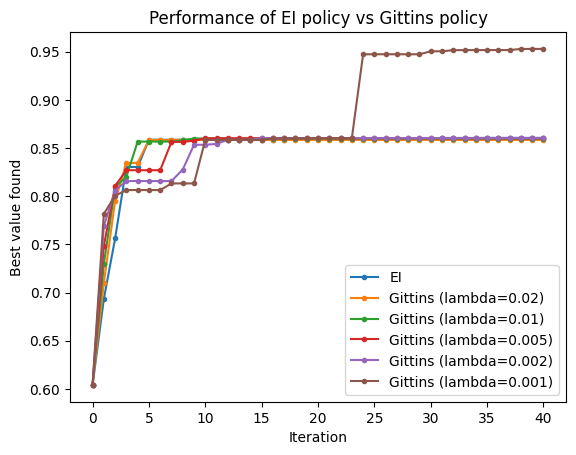

In [97]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    label = "Gittins (lambda={})".format(cost)
    plt.plot(GI_best_dict[cost], '.-', label=label)

# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI policy vs Gittins policy")

In [98]:
from botorch.acquisition import UpperConfidenceBound

seed = 42

maximize = True 

num_iterations = 40

torch.manual_seed(seed)

x = torch.rand(10, 4, device=device, dtype=dtype).requires_grad_(True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 
    
UCB_best = [best_f] # This will store the best value

for i in range(num_iterations):
    
    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)
            
    # Optimize UCB
    BoTorch_UCB = UpperConfidenceBound(model=model, beta=2.7, maximize=maximize)
    new_point, new_point_UCB = optimize_acqf(
        acq_function=BoTorch_UCB,
        bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]]),
        q=1,
        num_restarts=40,
        raw_samples=400,
        options={},
    )
    
    new_value = objective(new_point)
    
    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())
    
    #cross_validation(x,y,nu=0.5)

    
    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))
    
    if maximize:
        best_f = max(best_f, new_value.item())
    else:
        best_f = min(best_f, new_value.item())
        
    UCB_best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.02732422 0.41910017 1.         0.7322325 ]]
new value: 0.7361763119697571
best oberved value: 0.7361763119697571

Iteration: 1
new point: [[-0.28643322  0.306738    0.8863635   0.74330986]]
new value: 0.8107500672340393
best oberved value: 0.8107500672340393



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.39492965  0.5940162   0.94500774  1.        ]]
new value: 0.8231903910636902
best oberved value: 0.8231903910636902

Iteration: 3
new point: [[-0.61872065  0.5826272   1.          0.6266795 ]]
new value: 0.8006774187088013
best oberved value: 0.8231903910636902



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.6452025  0.147748   1.         1.       ]]
new value: 0.807350754737854
best oberved value: 0.8231903910636902

Iteration: 5
new point: [[-0.6780789   0.41878504  0.5930828   0.92014   ]]
new value: 0.7081360816955566
best oberved value: 0.8231903910636902



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.2876322   0.06765164  1.          1.        ]]
new value: 0.8551081418991089
best oberved value: 0.8551081418991089

Iteration: 7
new point: [[-0.36955267 -0.46722504  1.          1.        ]]
new value: 0.8019105195999146
best oberved value: 0.8551081418991089

Iteration: 8
new point: [[-0.4823286  -0.09662573  1.          0.6746964 ]]
new value: 0.836407482624054
best oberved value: 0.8551081418991089



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.41600183  0.19062531  1.          0.8719975 ]]
new value: 0.8562904000282288
best oberved value: 0.8562904000282288

Iteration: 10
new point: [[-0.40656686  0.02306018  1.          1.        ]]
new value: 0.8600863218307495
best oberved value: 0.8600863218307495

Iteration: 11
new point: [[-0.33817926 -0.03765669  1.          0.85520625]]
new value: 0.8455727100372314
best oberved value: 0.8600863218307495



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.33952612  0.25636727  1.          1.        ]]
new value: 0.857713520526886
best oberved value: 0.8600863218307495

Iteration: 13
new point: [[-0.396265    0.15381458  1.          1.        ]]
new value: 0.8599474430084229
best oberved value: 0.8600863218307495

Iteration: 14
new point: [[-0.38640139  0.13866869  1.          1.        ]]
new value: 0.8603460788726807
best oberved value: 0.8603460788726807



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.3039545   0.23990056  1.          1.        ]]
new value: 0.856541097164154
best oberved value: 0.8603460788726807

Iteration: 16
new point: [[-0.39350775  0.06001681  1.          1.        ]]
new value: 0.8604865670204163
best oberved value: 0.8604865670204163

Iteration: 17
new point: [[-0.39536607  0.20499086  1.          1.        ]]
new value: 0.8589374423027039
best oberved value: 0.8604865670204163



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.41177958  0.18586884  1.          0.8794949 ]]
new value: 0.8566274046897888
best oberved value: 0.8604865670204163

Iteration: 19
new point: [[-0.78370446 -0.09977434  1.          0.18377155]]
new value: 0.7824586629867554
best oberved value: 0.8604865670204163

Iteration: 20
new point: [[-0.36996368  0.04783456  0.8880145   1.        ]]
new value: 0.823692262172699
best oberved value: 0.8604865670204163



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.33240807  0.21804255  1.          1.        ]]
new value: 0.8585087060928345
best oberved value: 0.8604865670204163



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.37506506  0.21483016  1.          1.        ]]
new value: 0.8591454029083252
best oberved value: 0.8604865670204163

Iteration: 23
new point: [[-0.80804735 -0.8739583   1.          0.45742908]]
new value: 0.6988344788551331
best oberved value: 0.8604865670204163



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.34086388  0.1112242   1.          1.        ]]
new value: 0.8597534894943237
best oberved value: 0.8604865670204163

Iteration: 25
new point: [[-0.3832991   0.19227056  1.          0.8958938 ]]
new value: 0.8573222160339355
best oberved value: 0.8604865670204163



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.3725159   0.09695422  1.          1.        ]]
new value: 0.8605509996414185
best oberved value: 0.8605509996414185

Iteration: 27
new point: [[-0.3226196   0.16256265  1.          1.        ]]
new value: 0.8588697910308838
best oberved value: 0.8605509996414185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.3877173   0.21408758  1.          1.        ]]
new value: 0.8589349389076233
best oberved value: 0.8605509996414185

Iteration: 29
new point: [[-0.38309675  0.079125    1.          1.        ]]
new value: 0.8605784177780151
best oberved value: 0.8605784177780151



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.37970844  0.08711915  1.          1.        ]]
new value: 0.860588788986206
best oberved value: 0.860588788986206

Iteration: 31
new point: [[-0.38370633  0.15387301  1.          0.90758604]]
new value: 0.8578495383262634
best oberved value: 0.860588788986206



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-0.32248732  0.14082694  1.          1.        ]]
new value: 0.8589335083961487
best oberved value: 0.860588788986206

Iteration: 33
new point: [[-0.38406745  0.21859886  1.          1.        ]]
new value: 0.858904242515564
best oberved value: 0.860588788986206



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.3858994   0.07535841  1.          1.        ]]
new value: 0.8605705499649048
best oberved value: 0.860588788986206

Iteration: 35
new point: [[-0.38292184  0.08218763  1.          1.        ]]
new value: 0.8605884909629822
best oberved value: 0.860588788986206



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.3303076   0.19777776  1.          1.        ]]
new value: 0.8588173985481262
best oberved value: 0.860588788986206

Iteration: 37
new point: [[-0.3903876   0.19758789  1.          1.        ]]
new value: 0.8592660427093506
best oberved value: 0.860588788986206



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)
/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.3373442   0.09124518  1.          1.        ]]
new value: 0.8594303727149963
best oberved value: 0.860588788986206

Iteration: 39
new point: [[-0.39083767  0.07790335  1.          1.        ]]
new value: 0.8605695962905884
best oberved value: 0.860588788986206



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Text(0.5, 1.0, 'Performance of EI vs Gittins vs UCB')

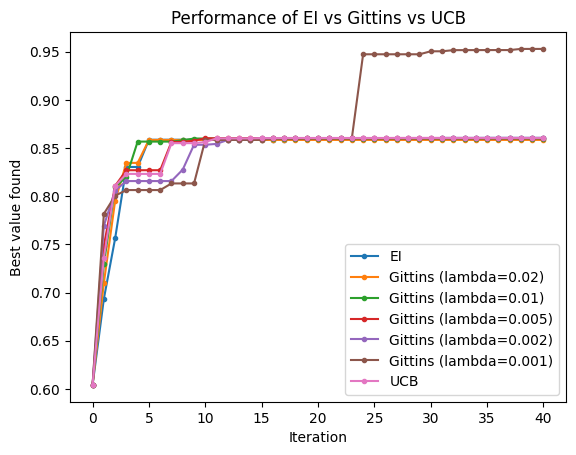

In [99]:
# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    label = "Gittins (lambda={})".format(cost)
    plt.plot(GI_best_dict[cost], '.-', label=label)
    
# Plotting UCB
plt.plot(UCB_best, '.-', label='UCB')

# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins vs UCB")

In [100]:
torch.manual_seed(seed)

lmbda = 0.01

x = torch.rand(10, 4, device=device, dtype=dtype).requires_grad_(True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 

GI_best = [best_f] # This will store the best value
stopping_time = []  # This will store the stopping times

for i in range(num_iterations):

    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

    # Optimize GI
    GI = GittinsIndex(model=model, cost=lmbda, maximize=maximize)
    if maximize:
        new_point, new_point_GI = optimize_acqf(
            acq_function=GI,
            bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]]),
            q=1,
            num_restarts=40,
            raw_samples=400,
            options={'method': 'L-BFGS-B'},
        )
    else:
        neg_GI = lambda X: -GI(X)
        new_point, new_point_neg_GI = optimize_acqf(
            acq_function=neg_GI,
            bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]]),
            q=1,
            num_restarts=40,
            raw_samples=400,
            options={'method': 'L-BFGS-B'},
        )
        new_point_GI = -new_point_neg_GI

    new_value = objective(new_point)

    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())

    #cross_validation(x,y,nu=0.5)


    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))

    if maximize:
        if new_point_GI.item() < best_f:
            stopping_time.append(i)
            lmbda = lmbda / 2
        best_f = max(best_f, new_value.item())
    else:
        if new_point_GI.item() > best_f:
            stopping_time.append(i)
            lmbda = lmbda / 2
        best_f = min(best_f, new_value.item())

    GI_best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.0392906  0.42102888 1.         0.7129568 ]]
new value: 0.7297431230545044
best oberved value: 0.7297431230545044

Iteration: 1
new point: [[-0.25541088  0.31382185  0.90019864  0.7362143 ]]
new value: 0.8093884587287903
best oberved value: 0.8093884587287903



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.35579345  0.53837365  0.92075914  1.        ]]
new value: 0.8202759027481079
best oberved value: 0.8202759027481079



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.45663863  0.12199193  1.          1.        ]]
new value: 0.856736958026886
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.7167457  0.3005253  1.         0.7895936]]
new value: 0.7712770700454712
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.46718392  0.07344183  0.70636517  1.        ]]
new value: 0.7671700716018677
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.2860778   0.18520677  1.          1.        ]]
new value: 0.8561781644821167
best oberved value: 0.856736958026886



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.38602084  0.24595714  1.          1.        ]]
new value: 0.8580703735351562
best oberved value: 0.8580703735351562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.33554226 -0.26877806  1.          1.        ]]
new value: 0.8312540650367737
best oberved value: 0.8580703735351562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.37544215  0.06463725  1.          0.8836568 ]]
new value: 0.8556450009346008
best oberved value: 0.8580703735351562



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 10
new point: [[-0.35972    0.1018495  1.         1.       ]]
new value: 0.8603375554084778
best oberved value: 0.8603375554084778



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-0.35832942  0.09896343  1.          1.        ]]
new value: 0.8602911233901978
best oberved value: 0.8603375554084778



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.36303788  0.11568613  1.          1.        ]]
new value: 0.8604249358177185
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-0.85234004 -0.8875259   1.          1.        ]]
new value: 0.710878312587738
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
new point: [[-0.5918514  -0.54575896  1.          0.38459298]]
new value: 0.7502997517585754
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.36537412  0.13313557  1.          1.        ]]
new value: 0.8604036569595337
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-0.3664644   0.13287412  1.          1.        ]]
new value: 0.8604173064231873
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.41458544  0.04130588  1.          1.        ]]
new value: 0.8601061701774597
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.3650422   0.13773787  1.          1.        ]]
new value: 0.8603721261024475
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.999169   -0.4878472   0.29377297 -0.01665832]]
new value: 0.5763811469078064
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-0.5387724 -0.1320612  1.         1.       ]]
new value: 0.8491336703300476
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.41900405  0.03254968  1.          1.        ]]
new value: 0.8599522709846497
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.44886443 -0.05345636  1.          0.8287394 ]]
new value: 0.8491519093513489
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.41360566  0.05546869  1.          1.        ]]
new value: 0.860173225402832
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-0.41015652  0.06800718  1.          1.        ]]
new value: 0.8602688312530518
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
new point: [[-0.4105271   0.14724883  1.          1.        ]]
new value: 0.859545886516571
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-0.810091   1.        -0.2615128  1.       ]]
new value: 0.6374589800834656
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.75344175  1.         -0.8278815  -0.29334742]]
new value: 0.6048697829246521
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.87359947 -0.4837346  -1.          1.        ]]
new value: 0.8032492995262146
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-1.         -1.         -1.          0.20616397]]
new value: 0.5178568363189697
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-0.37412375  0.17135814 -1.          1.        ]]
new value: 0.5880565643310547
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-1.        -0.6449827 -0.4640822  1.       ]]
new value: 0.8134136199951172
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-0.5953372  -1.         -0.60696864  1.        ]]
new value: 0.638619601726532
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-1.          0.06732497 -0.74199426  1.        ]]
new value: 0.772650420665741
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.784      1.         1.        -0.4701436]]
new value: 0.8190597891807556
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-1.          0.49794802  1.         -1.        ]]
new value: 0.6868309378623962
best oberved value: 0.8604249358177185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.29935214  1.          1.         -0.9119054 ]]
new value: 0.8794679045677185
best oberved value: 0.8794679045677185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.41759908  1.          0.3614347  -1.        ]]
new value: 0.6513438820838928
best oberved value: 0.8794679045677185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.2962818   1.          1.         -0.42761308]]
new value: 0.8488830924034119
best oberved value: 0.8794679045677185



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[ 0.19425115  1.          1.         -1.        ]]
new value: 0.8417366743087769
best oberved value: 0.8794679045677185



Text(0.5, 1.0, 'Performance of EI vs Gittins vs UCB')

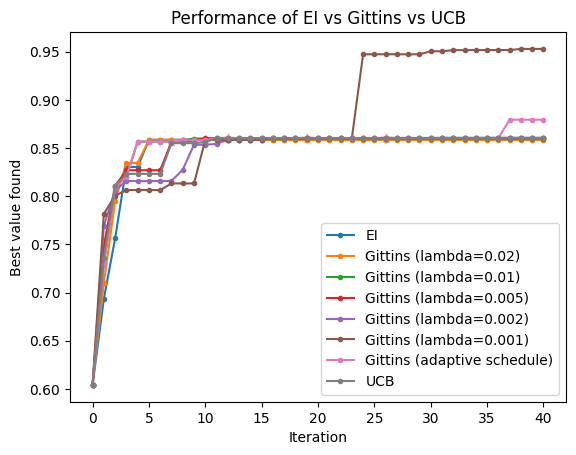

In [101]:
import numpy as np

# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    label = "Gittins (lambda={})".format(cost)
    plt.plot(GI_best_dict[cost], '.-', label=label)
    
# Plotting GI
plt.plot(GI_best, '.-', label='Gittins (adaptive schedule)')
plt.scatter(stopping_time, np.array(GI_best)[stopping_time], c='pink', marker='*', s=50)
    
# Plotting UCB
plt.plot(UCB_best, '.-', label='UCB')

# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins vs UCB")

In [102]:
lmbda

0.0003125

In [103]:
stopping_time

[7, 10, 12, 19, 26]

In [104]:
torch.manual_seed(seed)

lmbda = 0.02

x = torch.rand(10, 4, device=device, dtype=dtype).requires_grad_(True)
y = objective(x).unsqueeze(-1)  # add output dimension

if maximize:
    best_f = y.max().item() 
else:
    best_f = y.min().item() 

GI_best = [best_f] # This will store the best value
stopping_time = []  # This will store the stopping times

for i in range(num_iterations):

    # Fit the model
#     with torch.no_grad():  # Temporarily set all the requires_grad flags to false
    model = fit_gp_model(x.detach(), y.detach(), Yvar=None)

    # Optimize GI
    GI = GittinsIndex(model=model, cost=lmbda, maximize=maximize)
    if maximize:
        new_point, new_point_GI = optimize_acqf(
            acq_function=GI,
            bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]]),
            q=1,
            num_restarts=40,
            raw_samples=400,
            options={},
        )
    else:
        neg_GI = lambda X: -GI(X)
        new_point, new_point_neg_GI = optimize_acqf(
            acq_function=neg_GI,
            bounds=torch.tensor([[-1., -1., -1., -1.],[1., 1., 1., 1.]]),
            q=1,
            num_restarts=40,
            raw_samples=400,
            options={},
        )
        new_point_GI = -new_point_neg_GI

    new_value = objective(new_point)

    print("Iteration:", i)
    print("new point:", new_point.detach().numpy())
    print("new value:", new_value.item())

    #cross_validation(x,y,nu=0.5)


    # Add the new data
    x = torch.cat((x,new_point))
    y = torch.cat((y,new_value.unsqueeze(-1)))

    if maximize:
        if new_point_GI.item() < best_f:
            stopping_time.append(i)
            lmbda = lmbda / 2
        best_f = max(best_f, new_value.item())
    else:
        if new_point_GI.item() > best_f:
            stopping_time.append(i)
            lmbda = lmbda / 2
        best_f = min(best_f, new_value.item())

    GI_best.append(best_f)
    print("best oberved value:", best_f)
    print()

Iteration: 0
new point: [[0.07990743 0.4299673  1.         0.6566356 ]]
new value: 0.7099400162696838
best oberved value: 0.7099400162696838

Iteration: 1
new point: [[-0.15591066  0.33664924  0.94585365  0.7190615 ]]
new value: 0.7952448129653931
best oberved value: 0.7952448129653931



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 2
new point: [[-0.29475206  0.5028789   0.96662766  1.        ]]
new value: 0.8308466076850891
best oberved value: 0.8308466076850891



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 3
new point: [[-0.45270687  0.1251525   1.          1.        ]]
new value: 0.8570526242256165
best oberved value: 0.8570526242256165



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 4
new point: [[-0.6528289   0.32748812  0.79464054  0.82629085]]
new value: 0.7610570192337036
best oberved value: 0.8570526242256165



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 5
new point: [[-0.22712572  0.03398533  1.          1.        ]]
new value: 0.845367968082428
best oberved value: 0.8570526242256165



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 6
new point: [[-0.33818516  0.21156149  1.          1.        ]]
new value: 0.8588398694992065
best oberved value: 0.8588398694992065



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 7
new point: [[-0.52867043 -0.48050258  1.          1.        ]]
new value: 0.8234816193580627
best oberved value: 0.8588398694992065



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 8
new point: [[-0.38440174 -0.09019911  0.76104224  1.        ]]
new value: 0.7761874794960022
best oberved value: 0.8588398694992065



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 9
new point: [[-0.4629236  -0.12261819  1.          0.7315372 ]]
new value: 0.8379576206207275
best oberved value: 0.8588398694992065



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 10
new point: [[-0.38462368  0.07133728  1.          0.92683387]]
new value: 0.8578483462333679
best oberved value: 0.8588398694992065



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 11
new point: [[-1.         -0.69045854  1.          0.5698446 ]]
new value: 0.6728169918060303
best oberved value: 0.8588398694992065



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 12
new point: [[-0.41050786 -0.05760335  1.          1.        ]]
new value: 0.8582876920700073
best oberved value: 0.8588398694992065



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 13
new point: [[-0.38534257  0.07626281  1.          1.        ]]
new value: 0.860573410987854
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 14
new point: [[-0.38569278  0.12785523  1.          0.92118233]]
new value: 0.8582370281219482
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 15
new point: [[-0.6877323  1.         1.         1.       ]]
new value: 0.7291615605354309
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 16
new point: [[-0.18350598 -1.          1.          1.        ]]
new value: 0.6764867305755615
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 17
new point: [[-0.60564166 -0.04119173  1.          1.        ]]
new value: 0.8321935534477234
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 18
new point: [[-0.38011262  0.02606539  1.          1.        ]]
new value: 0.8599487543106079
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 19
new point: [[-0.3738017   0.08760679  1.          1.        ]]
new value: 0.8605388402938843
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 20
new point: [[-0.37966514  0.06108205  1.          0.9332207 ]]
new value: 0.8578054904937744
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 21
new point: [[-0.3730934   0.10351551  1.          1.        ]]
new value: 0.8605631589889526
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 22
new point: [[-0.38421237  0.01957501  1.          1.        ]]
new value: 0.8599075078964233
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 23
new point: [[-0.7736408   0.74347293  1.         -0.02410857]]
new value: 0.781487762928009
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 24
new point: [[-1.          0.993843    0.48520628 -0.6527779 ]]
new value: 0.7109365463256836
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 25
new point: [[-1.          0.07928824  1.         -0.9725767 ]]
new value: 0.650999903678894
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 26
new point: [[-1.          0.3570006  -0.26324186 -0.06150673]]
new value: 0.6755754351615906
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 27
new point: [[-0.7425204  1.        -0.6862834 -1.       ]]
new value: 0.49074500799179077
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 28
new point: [[-0.8623259   0.1144461   0.4876891  -0.12341969]]
new value: 0.778458297252655
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 29
new point: [[-1.          1.          0.44874337  0.17101036]]
new value: 0.7036382555961609
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 30
new point: [[-1.         -0.91429013  0.09527131 -0.5144107 ]]
new value: 0.46964678168296814
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 31
new point: [[-0.67856354  0.09296829  1.          0.11080706]]
new value: 0.8239631056785583
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 32
new point: [[-1.         0.2581092  1.         0.0402424]]
new value: 0.8201952576637268
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 33
new point: [[-0.63091683  0.33835682  1.          0.44860956]]
new value: 0.8131601214408875
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 34
new point: [[-0.349656    0.17427504  1.          1.        ]]
new value: 0.8597645163536072
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 35
new point: [[-0.38079375 -0.02669615  1.          1.        ]]
new value: 0.8585565090179443
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 36
new point: [[-0.35399666  0.15915056  1.          1.        ]]
new value: 0.860027015209198
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 37
new point: [[-0.3571888  0.1466717  1.         1.       ]]
new value: 0.860194742679596
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 38
new point: [[-0.3600631   0.13424805  1.          1.        ]]
new value: 0.8603212237358093
best oberved value: 0.860573410987854



/Users/qianxie/Library/Python/3.9/lib/python/site-packages/botorch/models/utils/assorted.py:173: InputDataWarning: Input data is not contained to the unit cube. Please consider min-max scaling the input data.
  warnings.warn(msg, InputDataWarning)


Iteration: 39
new point: [[-0.36304212  0.12005881  1.          1.        ]]
new value: 0.8604190945625305
best oberved value: 0.860573410987854



Text(0.5, 1.0, 'Performance of EI vs Gittins vs UCB')

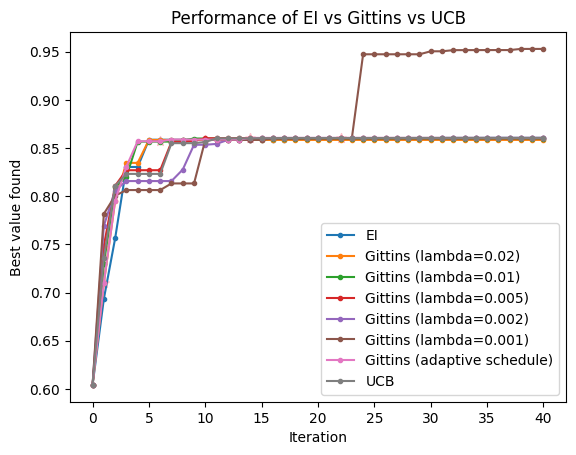

In [105]:
import numpy as np

# Plotting EI
plt.plot(EI_best, '.-', label='EI')

# Plotting Gittins
for cost in sorted(GI_best_dict.keys(), reverse=True):
    label = "Gittins (lambda={})".format(cost)
    plt.plot(GI_best_dict[cost], '.-', label=label)
    
# Plotting GI
plt.plot(GI_best, '.-', label='Gittins (adaptive schedule)')
plt.scatter(stopping_time, np.array(GI_best)[stopping_time], c='pink', marker='*', s=50)
    
# Plotting UCB
plt.plot(UCB_best, '.-', label='UCB')

# Adding legend
plt.legend()

plt.xlabel('Iteration')
plt.ylabel('Best value found')
plt.title("Performance of EI vs Gittins vs UCB")